# User-Based Collaberative Filtering
## Datasets Provided
The MovieLens-20M dataset is split over 6 .csv files
1. genome-tags:    Associates each movie tag with a number
2. tags:           Each user and what tags they have assigned to which movies, with timestamp
3. genome-scores:  Each tag's relevance to every movie as a double 0-1
4. ratings:        20M ratings users gave to movies they watched (0.5-5, steps of 0.5)
5. movies:         Each movie's ID number and name, as well as genres 
6. links:          Each movie's entry numbers in IMDB and themovieDB (seemingly irrelevant?)

MOVIE IDS ARE CONSISTENT ACROSS 'RATINGS', 'TAGS', 'MOVIES', AND 'LINKS'

## Methodology
As this filtering method is USER-based, it relies on user-provided ratings and tags.
A user's 'likes' can be represented by a bag of words (or tag IDs) made up of the tags associated with the movies they watch, as well as their ratings.

Our active user(s) (whose interests we are predicting) has the following structure for ratings, as an example:

| User | MovieID | Rating |
| --- | --- | --- |
| 123 | 456 | 2.5 |
| 123 | 983 | 3.5 |
| 123 | 234 | 5 |



In [18]:
# Import block
import pandas as pd
import numpy as np
import sklearn  # Comes with kNN method, may be useful
import math     # for exp() in distance adjustment
from scipy.spatial import distance
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

# Data loading block
genome_tags = pd.read_csv("genome-tags.csv") # get tags
user_tags = pd.read_csv("tags.csv", usecols=[0, 1, 2]) # get user-given tags, but not timestamp
genome_scores = pd.read_csv("genome-scores.csv")
ratings = pd.read_csv("ratings.csv", usecols=[0, 1, 2]) # get user-provided ratings
movies = pd.read_csv("movies.csv")
# links = pd.read_csv("links.csv")

############# DATA SAVING STEP ######################
# Set movie IDs to int32 from int64
movies["movieId"] = movies["movieId"].astype('int32')

# Change ratings from floats (0.5 to 5 in 0.5 increments) to integers (1-10)
# Change user ID and movie ID to int32 from int64
ratings["userId"] = ratings["userId"].astype('int32')
ratings["movieId"] = ratings["movieId"].astype('int32')
ratings["rating"] = (ratings["rating"] * 2).astype('int8') # Keep this in mind (1-10)

# Change movieId to int32 and tagId to int16
# Change relevance from float64 to float32
genome_scores["movieId"] = genome_scores["movieId"].astype('int32')
genome_scores["tagId"] = genome_scores["tagId"].astype('int16')
genome_scores["relevance"] = genome_scores["relevance"].astype('float32')
                     
# Change userId and movieId to int32
user_tags["userId"] = user_tags["userId"].astype('int32')
user_tags["movieId"] = user_tags["movieId"].astype('int32')
                     
# Change genome tag IDs to int16
genome_tags["tagId"] = genome_tags["tagId"].astype('int16')

print("Items in genome-tags:\t\t" + str(len(genome_tags.index)))
print("Items in user-tags:\t\t" + str(len(user_tags.index)))
print("Items in genome-scores:\t\t" + str(len(genome_scores.index)))
print("Items in ratings:\t\t" + str(len(ratings.index)))
print("Items in movies:\t\t" + str(len(movies.index)))

Items in genome-tags:		1128
Items in user-tags:		465564
Items in genome-scores:		11709768
Items in ratings:		20000263
Items in movies:		27278


In [5]:
display(genome_tags)
#display(user_tags)
# Get only the user tags that appear within the genome
user_tags = user_tags[user_tags["tag"].isin(genome_tags["tag"])].reset_index(drop=True)
#display(user_tags)
tags_list = genome_tags["tag"].values.tolist()
# Convert tags in user_tags to their respective number
user_tags["tag"] = user_tags["tag"].apply(lambda tag : 
                                          tags_list.index(tag)+1).astype('int16')
#isplay(user_tags)
display(ratings)
#display(user_tags["tag"].apply(lambda tag_id : tags_list.index(tag_id)+1)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


,userId,movieId,rating
0,1,2,7
1,1,29,7
2,1,32,7
3,1,47,7
4,1,50,7
...,...,...,...
20000258,138493,68954,9
20000259,138493,69526,9
20000260,138493,69644,6
20000261,138493,70286,10


In [19]:
num_users = ratings["userId"].iloc[-1] # Get number of users (by looking at value of the final user)
# who_watched_what array
# There are 138493 total users
WWW = np.zeros((num_users, 20))
# Genres are a pipe-separated list, and are selected from the following:
genres = ["Action", "Adventure", "Animation", "Children", "Comedy", "Crime", "Documentary", \
          "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", \
          "Sci-Fi", "Thriller", "War", "Western", "IMAX", "(no genres listed)"]

num_to_genre = {1 : "Action", 2 : "Adventure", 3 : "Animation", 4 : "Children", \
                5 : "Comedy", 6: "Crime", 7 : "Documentary", 8 : "Drama", \
                9 : "Fantasy", 10 : "Film-Noir", 11 : "Horror", 12 : "Musical", \
                13 : "Mystery", 14 : "Romance", 15 : "Sci-Fi", 16 : "Thriller", \
                17 : "War", 18 : "Western", 19 : "IMAX", 20 : "(no genres listed)"}

genre_to_num = {"Action" : 1, "Adventure" : 2, "Animation" : 3, "Children" : 4, \
                "Comedy" : 5, "Crime" : 6, "Documentary" : 7, "Drama" : 8, \
                "Fantasy" : 9, "Film-Noir" : 10, "Horror" : 11, "Musical" : 12, \
                "Mystery" : 13, "Romance" : 14, "Sci-Fi" : 15, "Thriller" : 16, \
                "War" : 17, "Western" : 18, "IMAX" : 19, "(no genres listed)" : 20}

genre_to_color = {"Action" : '#eb2813', "Adventure" : '#60c706', "Animation" : '#f5ef42', \
                  "Children" : '#14f5de', "Comedy" : '#f5ad14', "Crime" : '#e30766', \
                  "Documentary" : '#757575', "Drama" : '#b100fc', "Fantasy" : '#ffabf9', \
                  "Film-Noir" : '#303030', "Horror" : '#8a0000', "Musical" : '#0012d6', \
                  "Mystery" : '#4f0159', "Romance" : '#ed4040', "Sci-Fi" : '#2b9cff', \
                  "Thriller" : '#008c6e', "War" : '#ff0000', "Western" : '#cc5f00', 
                  "IMAX" : '#70fdff', "(no genres listed)" : '#4f3c57', \
                  None : "#4f3c57"}

WWW = pd.DataFrame(data=WWW, columns=genres)
display(WWW)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# Loop to generate who-watched-what matrix for user similarity calculations (such as k-means)
# For each user, estimate a distribution of their movie tastes
# - for each rating in ratings, get the respective movie's genres
# - Convert genres to their respective index in genre_to_num (corresponding column in WWW matrix)
# - For each genre for the current movie, add the rating (0.5 to 5) to that user's genre
# THIS LOOP TAKES A VERY LONG TIME (~8 hours)

WWW2 = np.zeros((num_users, 20))
display(WWW2.shape)
for rating_num in range(ratings.shape[0]):     # For every rating available
    r = ratings.iloc[rating_num] # Output the 'userId', 'movieId', and 'rating' given
    #r_genres = movies.loc[movies.movieId==movie_id].genres
    r_genres = [genre_to_num[g] for g in movies.loc[movies.movieId==r.movieId].genres.values[0].split("|")]
    #print(r_genres)
    for i in r_genres:
        WWW2[r.userId-1, i-1] += r.rating / 2 # add the score 
    #WWW2[r.userId, r.userId] += r.rating / 2
display(pd.DataFrame(WWW2))

# Save the results of the extremely time-consuming loop into a .csv for future use
np.savetxt('who_watched_what.csv', WWW2, delimiter=',')

(138493, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,246.0,276.5,36.5,68.5,153.0,80.0,0.0,162.0,261.5,0.0,168.5,11.0,65.0,43.5,148.5,158.0,33.0,13.5,8.5,0.0
1,88.0,82.0,3.0,3.0,39.0,5.0,0.0,74.0,2.0,5.0,64.0,6.0,18.0,23.0,106.0,81.0,17.0,9.0,3.0,0.0
2,251.0,211.0,15.0,43.0,211.0,90.0,4.0,245.0,86.0,3.0,126.0,24.0,48.0,65.0,372.0,213.0,28.0,13.0,0.0,0.0
3,46.0,23.0,8.0,15.0,39.0,19.0,0.0,30.0,11.0,0.0,0.0,8.0,8.0,14.0,15.0,45.0,4.0,4.0,0.0,0.0
4,81.0,95.0,28.0,46.0,98.0,29.0,0.0,113.0,41.0,0.0,3.0,35.0,7.0,63.0,46.0,65.0,4.0,10.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138488,31.0,23.5,9.0,12.0,40.0,48.0,0.0,80.0,17.5,8.5,7.5,0.0,25.0,19.0,15.5,43.5,4.0,4.0,4.0,0.0
138489,17.0,16.0,0.0,14.0,111.0,65.0,1.0,514.0,12.0,5.0,5.0,16.0,46.0,109.0,13.0,71.0,25.0,4.0,4.0,0.0
138490,15.5,20.5,12.5,14.5,26.5,9.5,0.0,15.5,9.0,0.0,8.0,5.0,0.0,3.0,7.0,11.0,0.0,0.0,5.5,0.0
138491,69.0,60.5,14.5,12.0,214.0,51.0,38.5,100.0,34.5,4.5,0.0,27.5,10.5,94.5,16.5,33.5,4.5,13.5,0.0,0.0


In [29]:
WWW = pd.read_csv("who_watched_what.csv", names=genres)
WWW.index = range(1,len(WWW)+1) # Set indeces to match userId

# Divide every row by its sum, to get a distribution that adds to 1 for each user
WWW = WWW.div(WWW.sum(axis=1), axis=0)
# display(WWW.sum(axis=1).unique()) # All rows sum to 1 or very, very close - this is good

# Add a column indicating everyone's total movies watched (for weighting purposes)
#WWW["Movies Watched"] = ratings.groupby("userId").count()["rating"]

movies_watched = ratings.groupby("userId")
num_movies_watched = ratings.groupby("userId").count()["rating"]
display(WWW)
display(num_movies_watched)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed)
1,0.127230,0.143005,0.018878,0.035428,0.079131,0.041376,0.000000,0.083786,0.135247,0.000000,0.087148,0.005689,0.033618,0.022498,0.076804,0.081717,0.017067,0.006982,0.004396,0.0
2,0.140127,0.130573,0.004777,0.004777,0.062102,0.007962,0.000000,0.117834,0.003185,0.007962,0.101911,0.009554,0.028662,0.036624,0.168790,0.128981,0.027070,0.014331,0.004777,0.0
3,0.122559,0.103027,0.007324,0.020996,0.103027,0.043945,0.001953,0.119629,0.041992,0.001465,0.061523,0.011719,0.023438,0.031738,0.181641,0.104004,0.013672,0.006348,0.000000,0.0
4,0.159170,0.079585,0.027682,0.051903,0.134948,0.065744,0.000000,0.103806,0.038062,0.000000,0.000000,0.027682,0.027682,0.048443,0.051903,0.155709,0.013841,0.013841,0.000000,0.0
5,0.103979,0.121951,0.035944,0.059050,0.125802,0.037227,0.000000,0.145058,0.052632,0.000000,0.003851,0.044929,0.008986,0.080873,0.059050,0.083440,0.005135,0.012837,0.019255,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138489,0.079082,0.059949,0.022959,0.030612,0.102041,0.122449,0.000000,0.204082,0.044643,0.021684,0.019133,0.000000,0.063776,0.048469,0.039541,0.110969,0.010204,0.010204,0.010204,0.0
138490,0.016221,0.015267,0.000000,0.013359,0.105916,0.062023,0.000954,0.490458,0.011450,0.004771,0.004771,0.015267,0.043893,0.104008,0.012405,0.067748,0.023855,0.003817,0.003817,0.0
138491,0.095092,0.125767,0.076687,0.088957,0.162577,0.058282,0.000000,0.095092,0.055215,0.000000,0.049080,0.030675,0.000000,0.018405,0.042945,0.067485,0.000000,0.000000,0.033742,0.0
138492,0.086358,0.075720,0.018148,0.015019,0.267835,0.063830,0.048185,0.125156,0.043179,0.005632,0.000000,0.034418,0.013141,0.118273,0.020651,0.041927,0.005632,0.016896,0.000000,0.0


userId
1         175
2          61
3         187
4          28
5          66
         ... 
138489     38
138490    151
138491     22
138492     82
138493    373
Name: rating, Length: 138493, dtype: int64

In [325]:
# k-Nearest Neighbor algorithm to find most similar users by genre distribution
# More avid watchers, with more movies watched, will have a smaller distance
# Total number of movies, used in weighting users who watch more
total_movies = len(movies.index);
display(total_movies)

# Provide a user to predict: 
active_id = 2468
active_user = WWW.loc[WWW.index==active_id]
display(active_user)

plt.pie(active_user[genres], labels=genres)

WWW2 = WWW.drop(active_id, axis=0) # Remove user from WWW
# Apply euclidean distance formula to all users, then sort
euclidean_distances = WWW2.apply(lambda user: distance.euclidean(user, active_user), axis=1)

display(euclidean_distances)

unsorted_distances = pd.DataFrame(euclidean_distances)
#euclidean_distances = pd.DataFrame(index = WWW2.index)
#euclidean_distances["Distance"] = 0
#display(euclidean_distances)

#for u in tqdm_notebook(WWW2.index):
#    dist = 0
#    u_info = WWW2.iloc[u]
#    for g in genres:
#        dist += (u_info[g] - active_user[g])**2
##    #print(dist)
#    euclidean_distances.iloc[u] = math.sqrt(dist) * math.exp(1 - (total_movies/movies_watched[u]))
#    #display(WWW2.iloc[u])

euclidean_distances.sort_values(inplace=True)
display(euclidean_distances.head())

#euclidean_distances = euclidean_distances.apply(lambda dist: dist * math.exp(total_movies-))

27278

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed)
2468,0.043529,0.024118,0.002941,0.009412,0.231765,0.055882,0.020588,0.245294,0.03,0.014118,0.0,0.012353,0.057647,0.144706,0.018824,0.061176,0.021176,0.006471,0.0,0.0


Z:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  app.launch_new_instance()


1         0.332167
2         0.345427
3         0.303153
4         0.263786
5         0.223246
            ...   
138489    0.200040
138490    0.282199
138491    0.278639
138492    0.159546
138493    0.206059
Length: 138492, dtype: float64

80387     0.039990
108819    0.042704
116922    0.043895
120120    0.045639
119349    0.045849
dtype: float64

# Start of Recommendation Step
1. Determine the active user (the one we are trying to recommend to)
2. Calculate the distance between the active user and all other users
3. Sort the resulting list of distances, to get the nearest neighbors

These nearest neighbors will compare the movies they have rated to the active user, and movies that fall outside of the common set will be recommended based on ratings.
```python
active_id=123456

euclidean_distances = WWW2.apply(lambda user: distance.euclidean(user, active_user), axis=1)
euclidean_distances.sort_values(inplace=True)
```

<IPython.core.display.Javascript object>


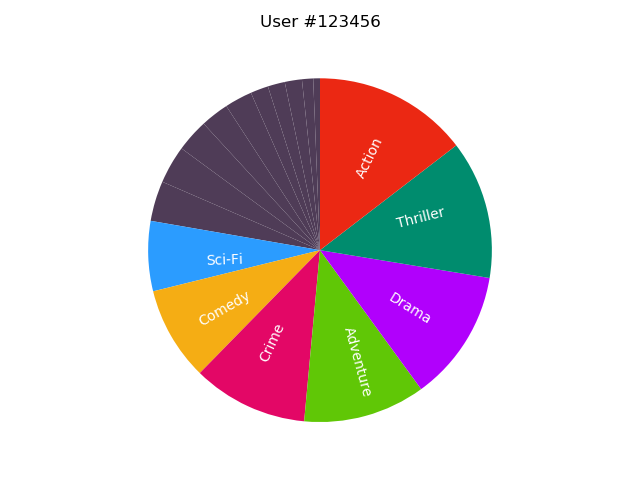

<IPython.core.display.Javascript object>


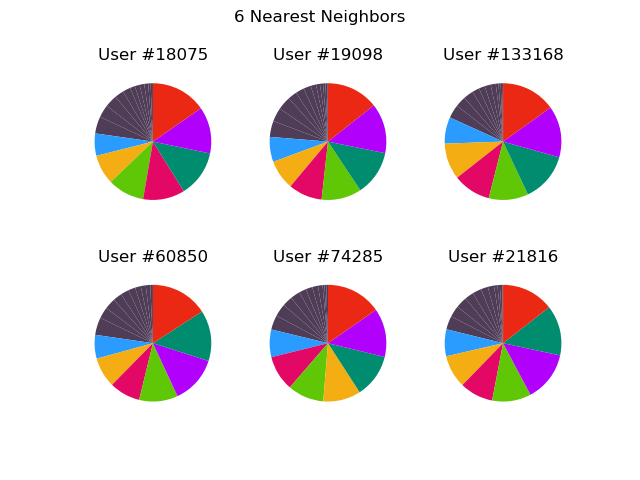

In [71]:
# Set active user
active_id=123456

%matplotlib notebook
total_plots = 6

active_user = WWW.loc[active_id]

WWW2 = WWW.drop(active_id, axis=0) # Remove user from WWW
# Apply euclidean distance formula to all users, then sort
euclidean_distances = WWW2.apply(lambda user: distance.euclidean(user, active_user), axis=1)
euclidean_distances.sort_values(inplace=True)

sorted_user = active_user[genres]; #display(sorted_user)
sorted_user = sorted_user.sort_values(kind='mergesort', ascending=True); #display(sorted_user)
%matplotlib notebook

# Generate list of labels
user_labels = []
for g in sorted_user.index:
    if sorted_user[g] > 0.05:
        user_labels.append(g)
    else:
        user_labels.append(None)

user_colors = [genre_to_color[l] for l in user_labels]
        
plt.pie(sorted_user, labels=user_labels, colors=user_colors, textprops=dict(color="w"), \
        rotatelabels=True, labeldistance=0.45, startangle=90)
plt.title("Active User #" + str(active_id))

###########################################################################
# Plot the 6 nearest neighbors, just to visualize the various distributions
###########################################################################
plt.tight_layout()
plt.figure()
plt.suptitle("6 Nearest Neighbors")
for i in range(total_plots):
    #print(i)
    plt.subplot(2, total_plots/2, i+1)
    #print(euclidean_distances.index[i])
    user = WWW.loc[euclidean_distances.index[i]]
    plt.title("User #" + str(user.name))
    #sorted_genres = sorted(user[genres])
    sorted_user = user[genres]
    sorted_user = sorted_user.sort_values(kind='mergesort', ascending=True)
    sorted_user = sorted_user[sorted_user.values > 0]
    #display(sorted_user)
    user_labels=[]
    for g in sorted_user.index:
        if sorted_user[g] > 0.05:
            user_labels.append(g)
        else:
            user_labels.append(None)
            
    user_colors = [genre_to_color[l] for l in user_labels] #labels=user_labels,
    plt.pie(sorted_user, colors=user_colors, textprops=dict(color="w"),\
        rotatelabels=True, labeldistance=0.45, startangle=90)

In [282]:
# Gather collection of nearest neighbors
# Also gather a collection of nearest neighbors with ratings, to get an aggregate for each movie
# This aggregate rating is used in weighting which movies to recommend
neighbors = []
neighbors_ratings = []
for i in euclidean_distances.head(10).index:
    neighbors.append(pd.DataFrame(movies_watched.get_group(i)["movieId"].reset_index(drop=True)))
    neighbors_ratings.append(pd.DataFrame(movies_watched.get_group(i)[["movieId", "rating"]].reset_index(drop=True)))

# Merge all the movies neighbors have watched into one big collection
neighbor_movies = neighbors[0]
for i in neighbors:
    neighbor_movies = pd.concat([neighbor_movies,i]).drop_duplicates().reset_index(drop=True)
neighbor_movies = neighbor_movies.sort_values(by="movieId").reset_index(drop=True)
neighbor_movies.set_index('movieId', inplace=True)

neighbor_movies["aggRating"] = 0.0 # Aggregate Rating, compiled from all users

# For each neighbor, add their ratings to the respective movie in 'Agg Rating'
for n in neighbors_ratings:
    #display(n)
    for r in n.iterrows():
        # Retrieve a movieId and its corresponding rating (1-10)
        n_rating = r[1]
        # Add this user's proper rating (0.5-5) to the respective movie
        neighbor_movies.loc[n_rating.movieId]["aggRating"] += n_rating.rating/2
        neighbor_movies.sort_values(by="aggRating", ascending=False, inplace=True)
#display(neighbor_movies)

# Remove the movies that the active user has already seen
user_seen = ratings[ratings.userId==active_id]["movieId"].reset_index(drop=True)

for seen in user_seen:
    # If the user has seen a movie and it exists in the aggregate, drop it
    if seen in neighbor_movies.index.values:
        neighbor_movies.drop(seen, axis=0, inplace=True)
        
#display(neighbor_movies)
        
###################################################
#      END OF RECOMMENDATION STEP                 #
###################################################
ids = neighbor_movies.head(10).index
for id in ids:
    display(movies.loc[movies.movieId==id])

#print("The most-recommended movie was " + str(movies[movies.movieId==neighbor_movies.index[0]].title.values[0]))

,movieId,title,genres
4897,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy


,movieId,title,genres
2486,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller


,movieId,title,genres
1017,1036,Die Hard (1988),Action|Crime|Thriller


,movieId,title,genres
108,110,Braveheart (1995),Action|Drama|War


,movieId,title,genres
1242,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi


,movieId,title,genres
46,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller


,movieId,title,genres
583,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi


,movieId,title,genres
453,457,"Fugitive, The (1993)",Thriller


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


,movieId,title,genres
6764,6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller


In [36]:
def recommend_movies(active_user_id):
    # Set active user
    active_id=active_user_id

    # Enable plotting in Jupyter Notebook
    %matplotlib notebook
    # Number of nearest neighbors to plot
    total_plots = 6

    active_user = WWW.loc[active_id]

    WWW2 = WWW.drop(active_id, axis=0) # Remove user from WWW
    # Apply euclidean distance formula to all users, then sort
    euclidean_distances = WWW2.apply(lambda user: distance.euclidean(user, active_user), axis=1)
    euclidean_distances.sort_values(inplace=True)

    sorted_user = active_user[genres]; #display(sorted_user)
    sorted_user = sorted_user.sort_values(kind='mergesort', ascending=True);
    %matplotlib notebook

    # Generate list of labels
    user_labels = []
    for g in sorted_user.index:
        if sorted_user[g] > 0.05:
            user_labels.append(g)
        else:
            user_labels.append(None)

    user_colors = [genre_to_color[l] for l in user_labels]

    plt.pie(sorted_user, labels=user_labels, colors=user_colors, textprops=dict(color="w"), \
            rotatelabels=True, labeldistance=0.45, startangle=90)
    plt.title("Active (User ID#" + str(active_id) + ")")

    ###########################################################################
    # Plot the 6 nearest neighbors, just to visualize the various distributions
    ###########################################################################
    plt.tight_layout()
    plt.figure()
    plt.suptitle("6 Nearest Neighbors")
    for i in range(total_plots):
        #print(i)
        plt.subplot(2, total_plots/2, i+1)
        #print(euclidean_distances.index[i])
        user = WWW.loc[euclidean_distances.index[i]]
        plt.title("User #" + str(user.name))
        #sorted_genres = sorted(user[genres])
        sorted_user = user[genres]
        sorted_user = sorted_user.sort_values(kind='mergesort', ascending=True)
        sorted_user = sorted_user[sorted_user.values > 0]
        #display(sorted_user)
        user_labels=[]
        for g in sorted_user.index:
            if sorted_user[g] > 0.05:
                user_labels.append(g)
            else:
                user_labels.append(None)

        user_colors = [genre_to_color[l] for l in user_labels] #labels=user_labels,
        plt.pie(sorted_user, colors=user_colors, textprops=dict(color="w"),\
            rotatelabels=True, labeldistance=0.45, startangle=90)
    # Gather collection of nearest neighbors
    # Also gather a collection of nearest neighbors with ratings,
    # to get an aggregate for each movie
    # This aggregate rating is used in weighting which movies to recommend
    neighbors = []
    neighbors_ratings = []
    for i in euclidean_distances.head(10).index:
        neighbors.append(pd.DataFrame(movies_watched.get_group(i)["movieId"]\
                                      .reset_index(drop=True)))
        neighbors_ratings.append(pd.DataFrame(movies_watched.get_group(i)\
                                              [["movieId", "rating"]].reset_index(drop=True)))

    # Merge all the movies neighbors have watched into one big collection
    neighbor_movies = neighbors[0]
    for i in neighbors:
        neighbor_movies = pd.concat([neighbor_movies,i]).drop_duplicates()\
        .reset_index(drop=True)
    neighbor_movies = neighbor_movies.sort_values(by="movieId").reset_index(drop=True)
    neighbor_movies.set_index('movieId', inplace=True)

    neighbor_movies["aggRating"] = 0.0 # Aggregate Rating, compiled from all users

    # For each neighbor, add their ratings to the respective movie in 'Agg Rating'
    for n in neighbors_ratings:
        #display(n)
        for r in n.iterrows():
            # Retrieve a movieId and its corresponding rating (1-10)
            n_rating = r[1]
            # Add this user's proper rating (0.5-5) to the respective movie
            neighbor_movies.loc[n_rating.movieId]["aggRating"] += n_rating.rating/2
            neighbor_movies.sort_values(by="aggRating", ascending=False, inplace=True)
    #display(neighbor_movies)

    # Remove the movies that the active user has already seen
    user_seen = ratings[ratings.userId==active_id]["movieId"].reset_index(drop=True)

    for seen in user_seen:
        # If the user has seen a movie and it exists in the aggregate, drop it
        if seen in neighbor_movies.index.values:
            neighbor_movies.drop(seen, axis=0, inplace=True)

    ###################################################
    #      END OF RECOMMENDATION STEP                 #
    ###################################################
    recommended_movies = pd.DataFrame(columns=["movieId","title","genres"])
    ids = neighbor_movies.head(10).index
    for id in ids:
        recommended_movies = recommended_movies.append(movies.loc[movies.movieId==id])
    #display(recommended_movies.style.hide_index())
    
    # Display distribution of genres among recommended movies
    rec_aggregate = np.zeros(20)
    for g in recommended_movies.genres:     # For every recommended movie, look at its genres
        g_split = [genre_to_num[genre] for genre in g.split("|")]
        for genre in g_split:
            rec_aggregate[genre-1] += 1
        
    agg_genres = pd.Series(rec_aggregate / 20)
    accuracy = 1 - distance.euclidean(agg_genres, active_user)
    
    agg_genres.index = range(1,len(agg_genres)+1)
    agg_genres.sort_values(inplace=True)
    #display(test)

    user_labels=[]
    for i in agg_genres.index:
        if agg_genres[i] > 0.05:
            user_labels.append(num_to_genre[i])
        else:
            user_labels.append(None)
    user_colors = [genre_to_color[l] for l in user_labels]
    
    plt.figure()
    plt.pie(agg_genres, startangle=90, labels=user_labels, textprops=dict(color="w"),\
                rotatelabels=True, labeldistance=0.45, colors=user_colors)

    display(accuracy)
    plt.title("Distribution of Recommended Movies' Genres \n(" + \
              str(round(accuracy, 4) * 100)+"% accuracy)")
    txt = "Accuracy determined as 1 - distance.euclidean(recommended_genres, active_user)"
    plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
    
    return recommended_movies

<IPython.core.display.Javascript object>


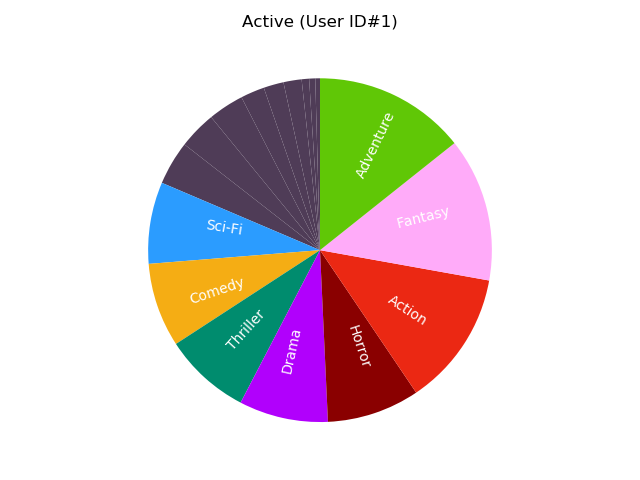

<IPython.core.display.Javascript object>


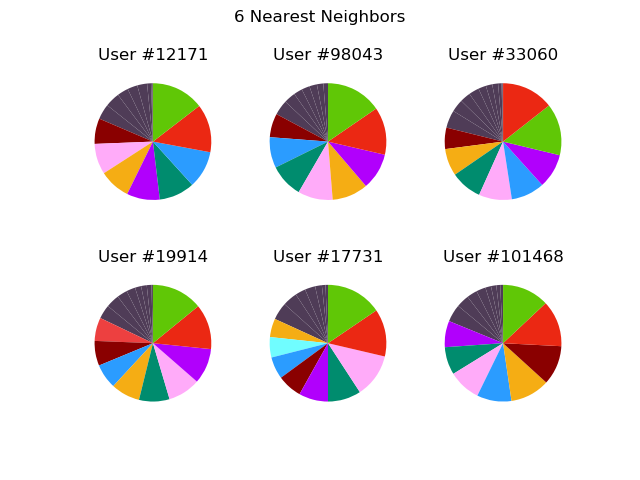

<IPython.core.display.Javascript object>


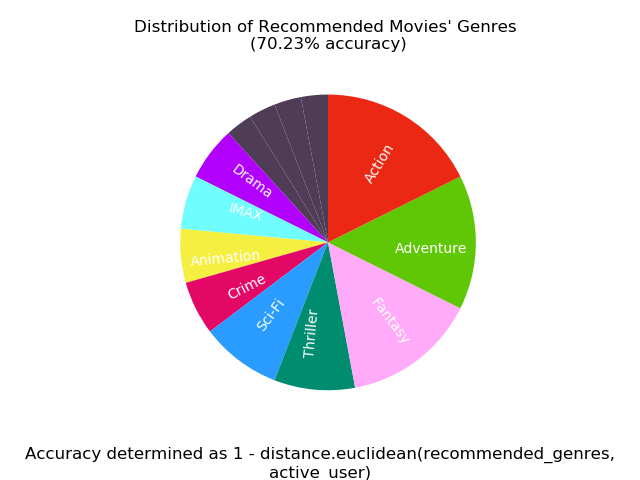

0.7023319707790763

,movieId,title,genres
12525,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
1184,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
11055,45722,Pirates of the Caribbean: Dead Man's Chest (2006),Action|Adventure|Fantasy
5519,5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy
2486,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1309,1339,Dracula (Bram Stoker's Dracula) (1992),Fantasy|Horror|Romance|Thriller
3702,3793,X-Men (2000),Action|Adventure|Sci-Fi
11354,48394,"Pan's Labyrinth (Laberinto del fauno, El) (2006)",Drama|Fantasy|Thriller
4790,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
10169,33794,Batman Begins (2005),Action|Crime|IMAX


In [37]:
recommend_movies(1)

In [25]:
test = pd.DataFrame(columns=["movieId","title","genres"])
ids = movies.head(15).index
for id in ids:
    test = test.append(movies.loc[movies.movieId==id])
        #display(movies.loc[movies.movieId==id])
display(test.style.hide_index())

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller


In [52]:
rec_aggregate = np.zeros(20)
display(rec_aggregate.shape)
for g in recs.genres:     # For every recommended movie, look at its genres
    #display(g)
    #g_split = g.split("|")
    #display(g_split)
    g_split = [genre_to_num[genre] for genre in g.split("|")]
    #display(g_split)
    for genre in g_split:
        rec_aggregate[genre-1] += 1
print(rec_aggregate)
    #r = ratings.iloc[rating_num] # Output the 'userId', 'movieId', and 'rating' given
    #r_genres = movies.loc[movies.movieId==movie_id].genres
    #r_genres = [genre_to_num[g] for g in movies.loc[movies.movieId==r.movieId].genres.values[0].split("|")]
    #print(r_genres)
    #for i in r_genres:
    #    re_aggregate[r.userId-1, i-1] += r.rating / 2 # add the score 
    #WWW2[r.userId, r.userId] += r.rating / 2

(20,)

[5. 3. 1. 1. 2. 2. 0. 1. 2. 0. 0. 0. 1. 0. 3. 5. 1. 0. 0. 0.]


<IPython.core.display.Javascript object>


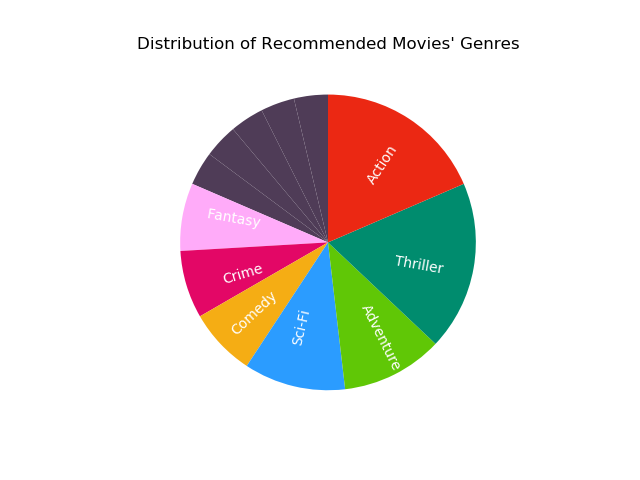

Text(0.5, 1.0, "Distribution of Recommended Movies' Genres")

In [92]:
test = pd.Series(rec_aggregate / 20)
test.index = range(1,len(test)+1)
test.sort_values(inplace=True)
#display(test)

user_labels=[]
for i in test.index:
    if test[i] > 0.05:
        user_labels.append(num_to_genre[i])
    else:
        user_labels.append(None)
user_colors = [genre_to_color[l] for l in user_labels]

%matplotlib notebook
plt.pie(test, startangle=90, labels=user_labels, textprops=dict(color="w"),\
            rotatelabels=True, labeldistance=0.45, colors=user_colors)
plt.title("Distribution of Recommended Movies' Genres")

In [25]:
#ratings.groupby(ratings.userId).get_group(1)
display(movies.iloc[[1, 28, 31]])
WWW.loc[1].Adventure = 7
WWW.loc[1].Children = 7
WWW.loc[1].Fantasy = 7
display(WWW[WWW.index==1])

,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy
28,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed)
1,0.0,7.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
